Credit to https://towardsdatascience.com/arima-forecasting-in-python-90d36c2246d3
For reference only now.

## Inspect dataset

In [1]:
import pandas as pd
df = pd.read_csv("top_200_features.csv", header = "infer", delimiter = None)
df.head()

,Unnamed: 0,Artist,Position,Streams,Track Name,acousticness,analysis_url,danceability,date,duration_ms,...,loudness,mode,region,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0,Ed Sheeran,1,51095759,Shape of You,0.5810,https://api.spotify.com/v1/audio-analysis/7qiZ...,0.825,2017-01-06--2017-01-13,233713.0,...,-3.183,0.0,global,0.0802,95.977,4.0,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,audio_features,spotify:track:7qiZfU4dY1lWllzX7mPBI3,0.9310
1,1,Ed Sheeran,2,35168298,Castle on the Hill,0.0232,https://api.spotify.com/v1/audio-analysis/6PCU...,0.461,2017-01-06--2017-01-13,261154.0,...,-4.868,1.0,global,0.0989,135.007,4.0,https://api.spotify.com/v1/tracks/6PCUP3dWmTjc...,audio_features,spotify:track:6PCUP3dWmTjcTtXY02oFdT,0.4710
2,2,The Weeknd,3,24261229,Starboy,0.1650,https://api.spotify.com/v1/audio-analysis/5aAx...,0.681,2017-01-06--2017-01-13,230453.0,...,-7.028,1.0,global,0.2820,186.054,4.0,https://api.spotify.com/v1/tracks/5aAx2yezTd8z...,audio_features,spotify:track:5aAx2yezTd8zXrkmtKl66Z,0.5350
3,3,Clean Bandit,4,21671209,Rockabye (feat. Sean Paul & Anne-Marie),0.4060,https://api.spotify.com/v1/audio-analysis/5knu...,0.720,2017-01-06--2017-01-13,251088.0,...,-4.068,0.0,global,0.0523,101.965,4.0,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,audio_features,spotify:track:5knuzwU65gJK7IF5yJsuaW,0.7420
4,4,ZAYN,5,21513043,I Don’t Wanna Live Forever (Fifty Shades Darke...,0.0631,https://api.spotify.com/v1/audio-analysis/3NdD...,0.735,2017-01-06--2017-01-13,245200.0,...,-8.374,1.0,global,0.0585,117.973,4.0,https://api.spotify.com/v1/tracks/3NdDpSvN911V...,audio_features,spotify:track:3NdDpSvN911VPGivFlV5d0,0.0862


In [2]:
df.columns

Index(['Unnamed: 0', 'Artist', 'Position', 'Streams', 'Track Name',
       'acousticness', 'analysis_url', 'danceability', 'date', 'duration_ms',
       'energy', 'id_caller', 'id_other', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'region', 'speechiness', 'tempo',
       'time_signature', 'track_href', 'type', 'uri', 'valence'],
      dtype='object')

In [3]:
s = df["danceability"].isna()
indices = s[s == True].index.values.tolist()
df = df.drop(index=indices)
df = df.reset_index()

In [4]:
features = df.select_dtypes(include = ["float64"]) # get the numeric columns

In [5]:
dates = []
for i in range(0, df.shape[0], 200): # extract the date of every top 200 list
    dates.append(df['date'][i][:10])

In [6]:
feature_mean = pd.DataFrame(columns = features.columns, index = pd.to_datetime(dates))
for feature in features.columns:
    average = []
    for i in range(0, df.shape[0], 200):
        average.append(df[feature][i:i+200].mean())
    feature_mean[feature] = average

In [7]:
feature_mean = feature_mean.asfreq(freq = "W", method = 'bfill')

## Manually estimating model using ARIMA

In [8]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [9]:
timeseries = feature_mean["acousticness"]
print("p-value:", adfuller(timeseries.dropna())[1])

p-value: 0.4345311936767221


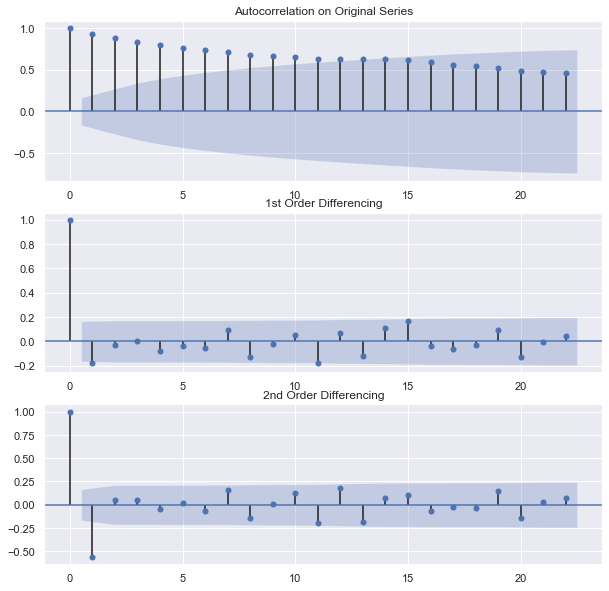

In [10]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1, title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2, title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3, title="2nd Order Differencing")

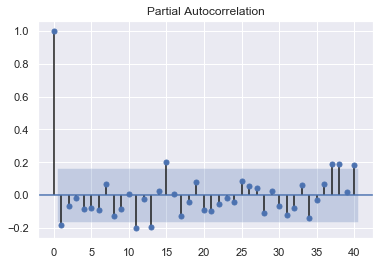

In [11]:
plot_pacf(timeseries.diff().dropna(), lags=40) #knowing d=1 we apply diff() once
plt.show()

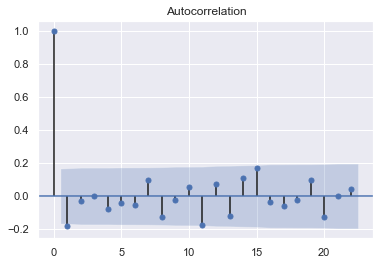

In [12]:
plot_acf(timeseries.diff().dropna())
plt.show()

In [13]:
model = ARIMA(timeseries, order=(1, 1, 1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.acousticness   No. Observations:                  139
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 407.424
Method:                       css-mle   S.D. of innovations              0.013
Date:                Tue, 04 Feb 2020   AIC                           -806.848
Time:                        11:11:11   BIC                           -795.110
Sample:                    01-15-2017   HQIC                          -802.078
                         - 09-08-2019                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005      0.000      1.407      0.162      -0.000       0.001
ar.L1.D.acousticness     0.7630      0.141      5.427      0.000       0.487       1.039
ma.L1.D.acousticness    -0.9335      0.094     -9.967      0.000      -1.117      -0.750
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3106           +0.0000j            1.3106            0.0000
MA.1            1.0712           +0.0000j            1.0712            0.0000
-----------------------------------------------------------------------------
"""

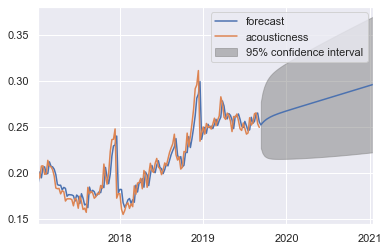

In [14]:
graph = results.plot_predict(1, 210)
plt.show()

## Auto_arima

In [15]:
import pmdarima as pm
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel
def plotarima(n_periods, timeseries, automodel):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, return_conf_int=True)
    # Weekly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], periods=n_periods, freq="W")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries)
    plt.plot(fc_series, color="red")
    plt.xlabel("date")
    plt.ylabel(timeseries.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", alpha=.25)
    plt.legend(("past", "forecast", "95% confidence interval"), loc="upper left")
    plt.show()

In [16]:
automodel = arimamodel(feature_mean["acousticness"])
automodel.summary()

Fit ARIMA: order=(1, 1, 1); AIC=-806.848, BIC=-795.110, Fit time=0.338 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-801.692, BIC=-795.823, Fit time=0.012 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-804.359, BIC=-795.555, Fit time=0.041 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-804.923, BIC=-796.119, Fit time=0.052 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-801.046, BIC=-786.373, Fit time=0.251 seconds
Fit ARIMA: order=(1, 1, 2); AIC=-801.290, BIC=-786.617, Fit time=0.272 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-804.831, BIC=-787.225, Fit time=0.524 seconds
Total fit time: 1.501 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  139
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 407.424
Method:                       css-mle   S.D. of innovations              0.013
Date:                Tue, 04 Feb 2020   AIC                           -806.848
Time:                        11:11:15   BIC                           -795.110
Sample:                             1   HQIC                          -802.078
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.407      0.162      -0.000       0.001
ar.L1.D.y      0.7630      0.141      5.427      0.000       0.487       1.039
ma.L1.D.y     -0.9335      0.094     -9.967      0.000      -1.117      -0.750
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3106           +0.0000j            1.3106            0.0000
MA.1            1.0712           +0.0000j            1.0712            0.0000
-----------------------------------------------------------------------------
"""

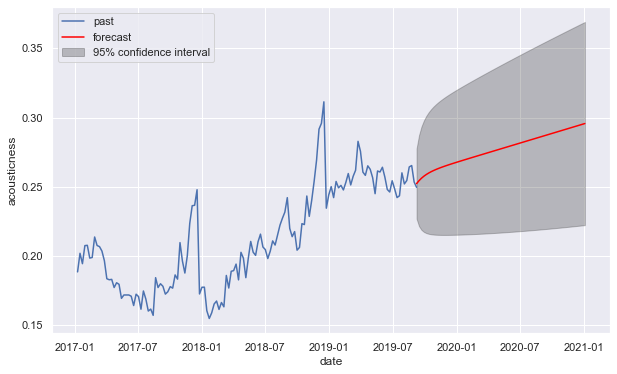

In [17]:
plotarima(70, feature_mean["acousticness"], automodel)